## 고고학 연구동향 연구(가제)
* [DBpia-Crawler](https://github.com/ChanToRe/DBpia-Crawler)를 통해 수집된 고고학 논문을 분석하여 2000년 이후 고고학 연구 동향을 살핌
* 워드클라우드 시각화 기법과 토픽 모델링 기법을 활용하여 연구동향을 분석

### 설치
```bash
pip install tqdm
pip install pandas
pip install matplotlib
pip install konlpy
pip install wordcloud
```

### 진행 계획
1. 크롤러 개발 (2022/01/26 완료)
2. 데이터 체크 및 한자 번역 (2022/01/31 완료)
3. 명사 추출 및 빈도 체크 (2022/02/01 완료) 
4. 워드 클라우드 적용 확인 (2022/02/02 완료)
5. 불용어 지정 . . . .

In [84]:
import pandas as pd
import hanja
from tqdm import tqdm
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from collections import Counter
import csv

In [85]:
#데이터 로드 & 한글 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic'
data = pd.read_csv('./Data-before.csv')
df = pd.DataFrame(data)

In [86]:
#제목 한자 번역
before_title = df[['title']] #제목 추출
list_before_title = before_title.values.tolist() #제목 리스트화
after_title = [] #번역 후 제목 리스트


for i in tqdm(range(len(list_before_title))):
    trans = hanja.translate(list_before_title[i], "substitution")
    after_title.append(trans)

100%|██████████| 2705/2705 [00:00<00:00, 11304.08it/s]


In [87]:
trans_result = df.assign(translate_title = after_title)
DB = pd.DataFrame(trans_result)
sort_DB = DB.sort_values(by=['date'])
#DB.to_excel("~/Desktop/result.xlsx")

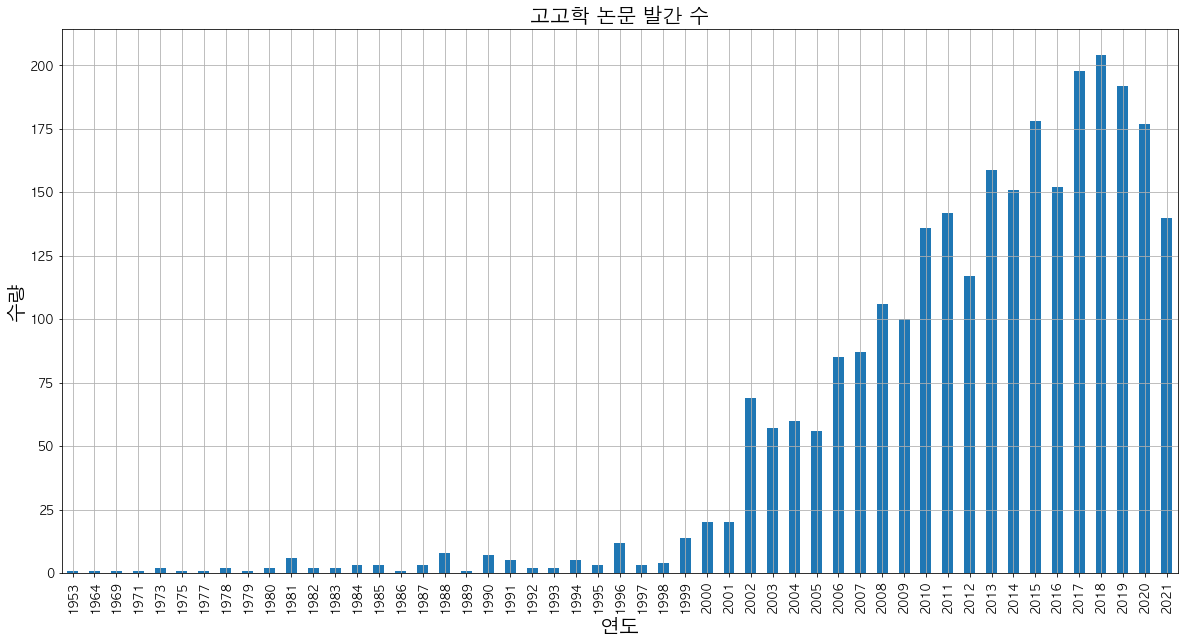

In [88]:
#고고학 논문 발간 수 그래프
sort_DB["date"].value_counts().sort_index().plot(kind='bar')
plt.rcParams["figure.figsize"] = (20,10)
plt.title("고고학 논문 발간 수", fontsize=20)
plt.xlabel("연도", fontsize=20)
plt.ylabel("수량", fontsize=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

In [89]:
#불용어 처리
#고고학, 연구, 중심, 대한, 지역

In [90]:
#분기별 구분
date_trash = trans_result[trans_result['date'] < 2000] #2000년대 이전

#2000년대 발간 논문
date_zero = trans_result[(trans_result['date'] >= 2000) & (trans_result['date'] < 2010)]
date_zero_title = pd.DataFrame(date_zero['translate_title'])
date_zero_title.to_csv("./date_zero_title.csv", sep = "\t", index=False)
zero = open("./date_zero_title.csv", 'r', encoding="UTF-8")
data_zero = zero.read()
zero.close()

#2010년대 발간 논문
date_ten = trans_result[(trans_result['date'] >= 2010) & (trans_result['date'] < 2020)] 
date_ten_title = pd.DataFrame(date_ten['translate_title'])
date_ten_title.to_csv("./date_ten_title.csv", sep = "\t", index=False)
ten = open("./date_ten_title.csv", 'r', encoding="UTF-8")
data_ten = ten.read()
ten.close()

#2020년대 발간 논문
date_twenty = trans_result[trans_result['date'] > 2019] 
date_twenty_title = pd.DataFrame(date_twenty['translate_title'])
date_twenty_title.to_csv("./date_twenty_title.csv", sep = "\t", index=False)
twenty = open("./date_twenty_title.csv", 'r', encoding="UTF-8")
data_twenty = twenty.read()
twenty.close()

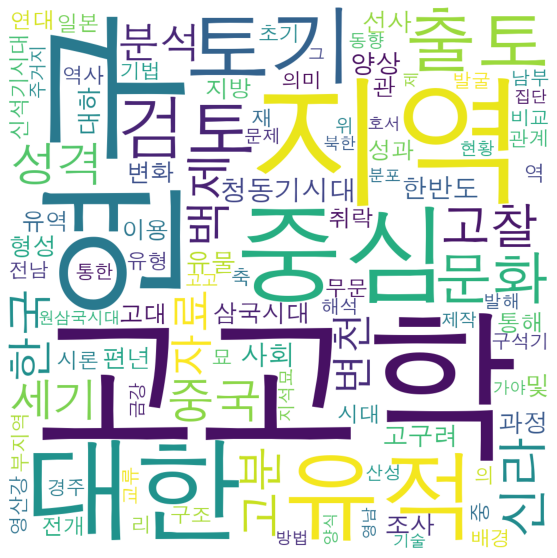

In [102]:
#Okt 생성
okt = Okt()
wc = WordCloud(width=1000, height=1000, random_state=0, max_words=100, max_font_size=300 ,background_color="white", font_path=r'~/Library/Fonts/AppleGothic.ttf')

#2000년대 발간 논문 명사 빈도 카운트
zero_noun = okt.nouns(data_zero)
zero_count = Counter(zero_noun)
zero_noun_list = zero_count.most_common(100)
plt.axis("off")
plt.imshow(wc.generate_from_frequencies(dict(zero_noun_list)))

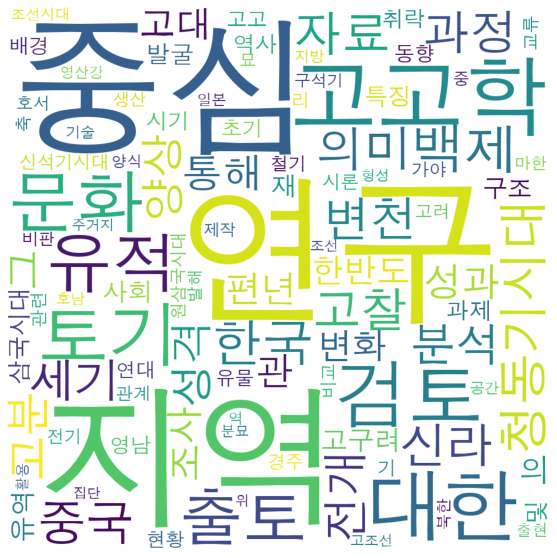

In [103]:
#2010년대 발간 논문 명사 빈도 카운트
ten_noun = okt.nouns(data_ten)
ten_count = Counter(ten_noun)
ten_noun_list = ten_count.most_common(100)
plt.axis("off")
plt.imshow(wc.generate_from_frequencies(dict(ten_noun_list)))

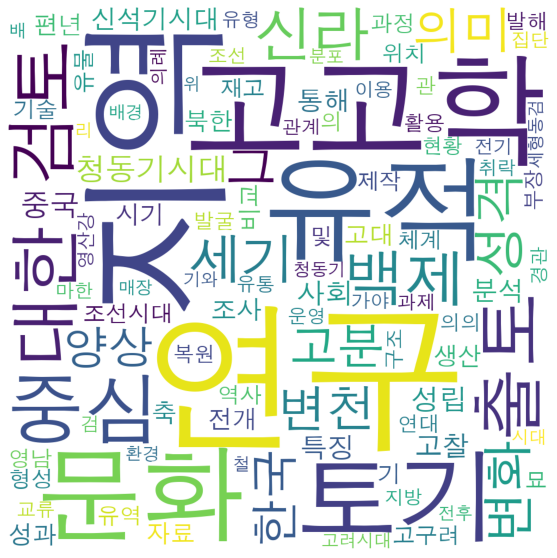

In [104]:
#2020년대 발간 논문 명사 빈도 카운트
twenty_noun = okt.nouns(data_twenty)
twenty_count = Counter(twenty_noun)
twenty_noun_list = twenty_count.most_common(100)
plt.axis("off")
plt.imshow(wc.generate_from_frequencies(dict(twenty_noun_list)))